# Table of Contents
- [Introduction](#Introduction)
- [Data Cleansing](#Data-Cleansing)
- [Data Visualization](#Data-Visualization)
- [Model Training and Evaluation](#model-training-and-evaluation)

#Introduction

In this analysis, I examine crop yields, in relation to several variables including yearly rainfall, temperatures, and pesticide use. I then use machine learning to make future yield predictions. The data comes from the FAO (Food and Agriculture Organization) and World Data Bank. The yields are measured in hectograms per hectare. 

by Nathaniel Cekay

In [1]:
import os
import csv
import numpy as np
import pandas as pd
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as py
import plotly.express as px
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import layers
from keras.regularizers import l2
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import joblib
from sklearn.model_selection import cross_val_score

2024-12-14 10:47:46.526801: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-14 10:47:46.526887: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-14 10:47:46.529927: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


#Data-Cleansing

In [2]:
df = pd.read_csv('/kaggle/input/crop-yield-prediction-dataset/yield_df.csv')

In [3]:
df = df.rename({'hg/ha_yield': 'Yield'}, axis='columns') #renaming column 
df = df.rename({'Unnamed: 0': 'ID'}, axis='columns')
df = df.rename({'pesticides_tonnes': 'Pesticide_Tons'}, axis='columns')
df = df.rename({'average_rain_fall_mm_per_year': 'Avg_rainfall_mm_per_year'}, axis='columns')
df = df.rename({'avg_temp': 'Avg_temp'}, axis='columns')
df = df.rename({'Area': 'Location'}, axis='columns')

In [4]:
missing = df.isna().sum()

print(missing)

ID                          0
Location                    0
Item                        0
Year                        0
Yield                       0
Avg_rainfall_mm_per_year    0
Pesticide_Tons              0
Avg_temp                    0
dtype: int64


In [5]:
df.head()

,ID,Location,Item,Year,Yield,Avg_rainfall_mm_per_year,Pesticide_Tons,Avg_temp
0,0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


#Data-Visualization

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28242 entries, 0 to 28241
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        28242 non-null  int64  
 1   Location                  28242 non-null  object 
 2   Item                      28242 non-null  object 
 3   Year                      28242 non-null  int64  
 4   Yield                     28242 non-null  int64  
 5   Avg_rainfall_mm_per_year  28242 non-null  float64
 6   Pesticide_Tons            28242 non-null  float64
 7   Avg_temp                  28242 non-null  float64
dtypes: float64(3), int64(3), object(2)
memory usage: 1.7+ MB


In [7]:
df_numeric = df.select_dtypes(include=['int', 'float64']) 

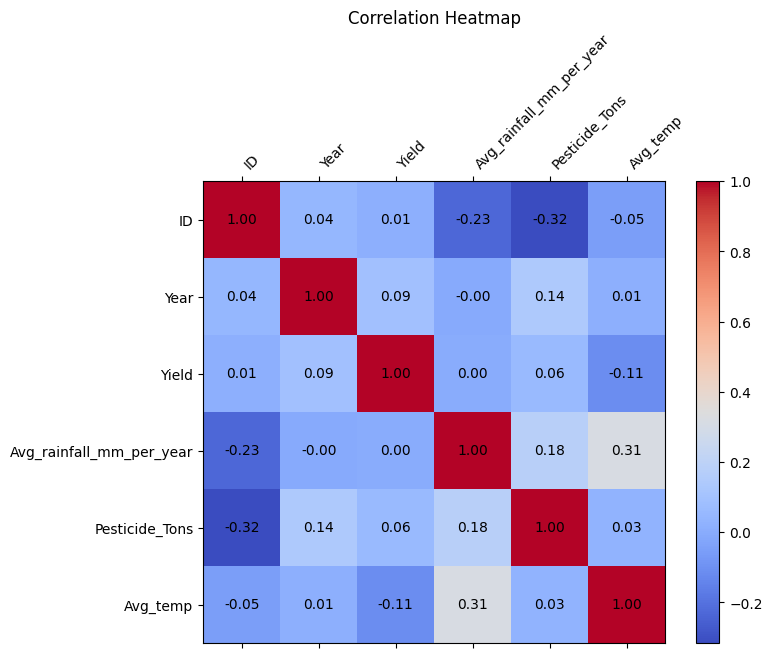

In [8]:
correlation_matrix = df_numeric.corr()

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(correlation_matrix, cmap="coolwarm")

fig.colorbar(cax)

ax.set_xticks(range(len(correlation_matrix.columns)))
ax.set_yticks(range(len(correlation_matrix.columns)))
ax.set_xticklabels(correlation_matrix.columns, rotation=45, ha="left")
ax.set_yticklabels(correlation_matrix.columns)

for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        ax.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}",
                ha="center", va="center", color="black")

plt.title("Correlation Heatmap")
plt.show()

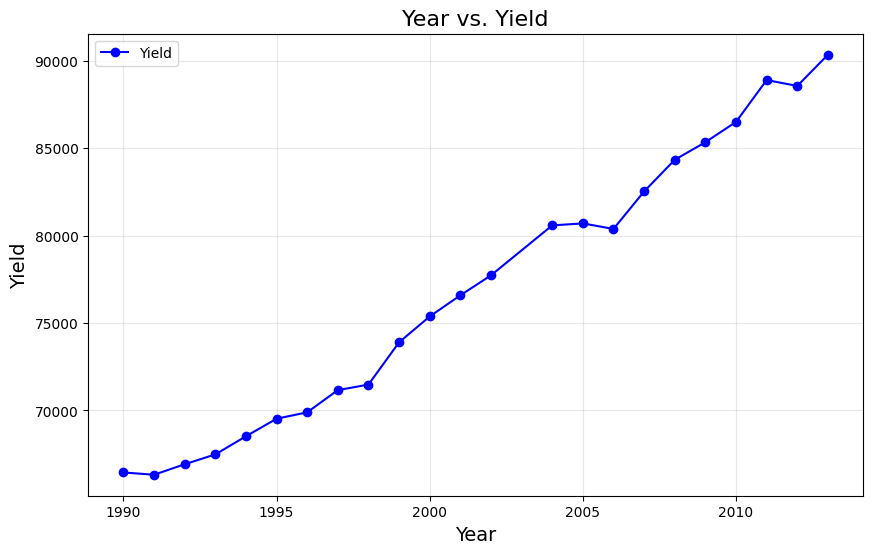

In [9]:
grouped_df = df.groupby('Year', as_index=False)['Yield'].mean()

plt.figure(figsize=(10, 6))
plt.plot(grouped_df['Year'], grouped_df['Yield'], marker='o', linestyle='-', color='blue', label='Yield')

plt.xlabel('Year', fontsize=14)
plt.ylabel('Yield', fontsize=14)
plt.title('Year vs. Yield', fontsize=16)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

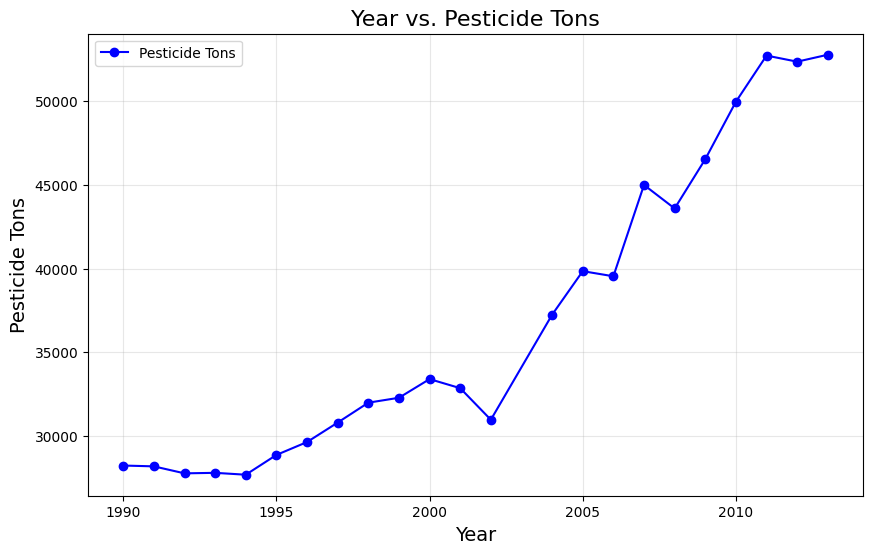

In [10]:
grouped_df = df.groupby('Year', as_index=False)['Pesticide_Tons'].mean()

plt.figure(figsize=(10, 6))
plt.plot(grouped_df['Year'], grouped_df['Pesticide_Tons'], marker='o', linestyle='-', color='blue', label='Pesticide Tons')

plt.xlabel('Year', fontsize=14)
plt.ylabel('Pesticide Tons', fontsize=14)
plt.title('Year vs. Pesticide Tons', fontsize=16)

plt.legend()
plt.grid(alpha=0.3)
plt.show()

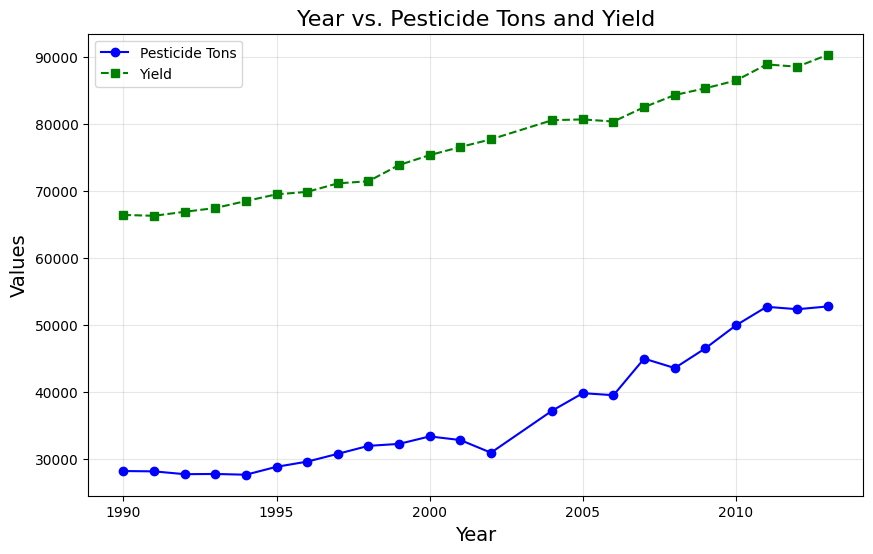

In [11]:
grouped_df = df.groupby('Year', as_index=False).agg({'Pesticide_Tons': 'mean', 'Yield': 'mean'})

plt.figure(figsize=(10, 6))

plt.plot(grouped_df['Year'], grouped_df['Pesticide_Tons'], marker='o', linestyle='-', color='blue', label='Pesticide Tons')

plt.plot(grouped_df['Year'], grouped_df['Yield'], marker='s', linestyle='--', color='green', label='Yield')

plt.xlabel('Year', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.title('Year vs. Pesticide Tons and Yield', fontsize=16)

plt.legend()
plt.grid(alpha=0.3)
plt.show()


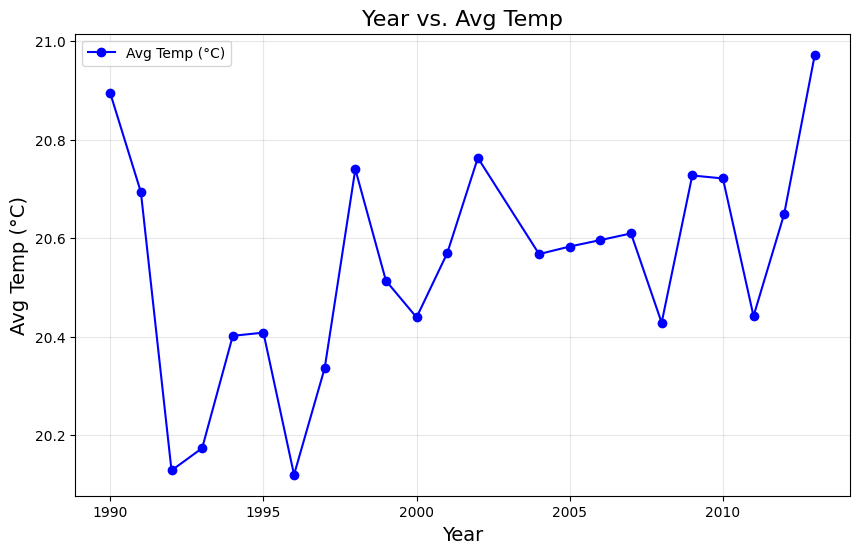

In [12]:
grouped_df = df.groupby('Year', as_index=False)['Avg_temp'].mean()

plt.figure(figsize=(10, 6))

plt.plot(grouped_df['Year'], grouped_df['Avg_temp'], marker='o', linestyle='-', color='blue', label='Avg Temp (°C)')

plt.xlabel('Year', fontsize=14)
plt.ylabel('Avg Temp (°C)', fontsize=14)
plt.title('Year vs. Avg Temp', fontsize=16)
plt.legend()
plt.grid(alpha=0.3)
plt.show()


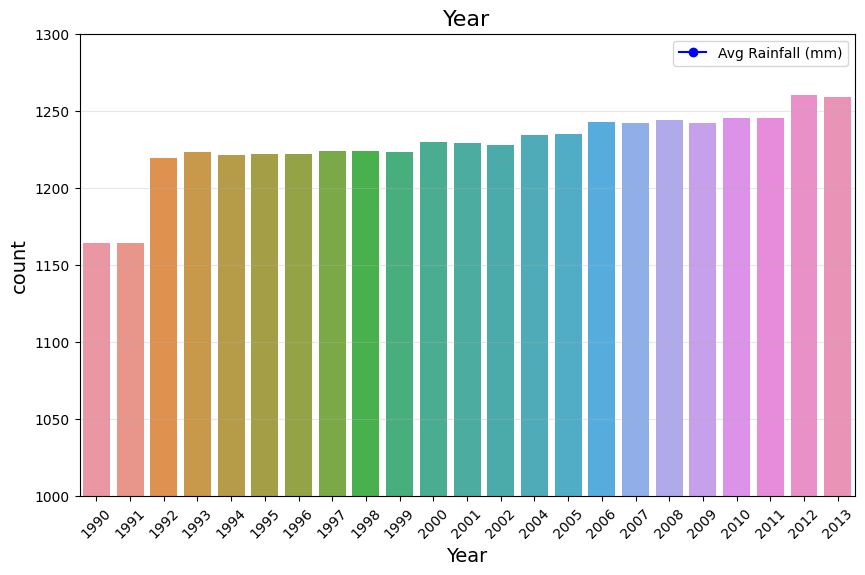

In [13]:
grouped_df = df.groupby('Year', as_index=False)['Avg_rainfall_mm_per_year'].mean()

plt.figure(figsize=(10, 6))

plt.plot(grouped_df['Year'], grouped_df['Avg_rainfall_mm_per_year'], marker='o', linestyle='-', color='blue', label='Avg Rainfall (mm)')

plt.xlabel('Year', fontsize=14)
plt.ylabel('Avg Rainfall (mm)', fontsize=14)
plt.title('Year vs. Avg Rainfall', fontsize=16)
plt.legend()

plt.grid(alpha=0.3)
year_count = sns.countplot(data=df, x='Year')
year_count.set_xticklabels(year_count.get_xticklabels(), rotation=45)
plt.ylim(1000, 1300)
plt.title('Year', fontsize=16)
plt.show()
plt.show()


In [14]:
df_backup = df #backing up the data

In [15]:
df = df.drop(columns=['ID'])

#model-training-and-evaluation

In [16]:
y = df['Yield']

In [17]:
X = df[['Location', 'Item', 'Avg_rainfall_mm_per_year', 'Pesticide_Tons', 'Avg_temp']]

In [18]:
print(f'X shape: {X.shape}, y shape: {y.shape}')


X shape: (28242, 5), y shape: (28242,)


In [19]:
numerical = X.drop(['Location','Item'], axis=1)
numerical.head()

,Avg_rainfall_mm_per_year,Pesticide_Tons,Avg_temp
0,1485.0,121.0,16.37
1,1485.0,121.0,16.37
2,1485.0,121.0,16.37
3,1485.0,121.0,16.37
4,1485.0,121.0,16.37


In [20]:
categorical = X.filter(['Location','Item'])

In [21]:
cat_numerical = pd.get_dummies(categorical,drop_first=True)

In [22]:
X = pd.concat([numerical, cat_numerical], axis = 1)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [24]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

In [25]:
lin_reg = LinearRegression()
model_lr = lin_reg.fit(X_train, y_train)
y_pred = model_lr.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-squared Score:', metrics.r2_score(y_test, y_pred))

mae_lr = metrics.mean_absolute_error(y_test, y_pred)
mse_lr = metrics.mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
r2_lr = metrics.r2_score(y_test, y_pred)

Mean Absolute Error: 29598.78713979063
Mean Squared Error: 1841061061.559241
Root Mean Squared Error: 42907.58745908748
R-squared Score: 0.7461890930615627


In [26]:
scores = cross_val_score(model_lr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("Cross-Validation RMSE:", (-scores.mean())**0.5)

Cross-Validation RMSE: 42823.15536059555


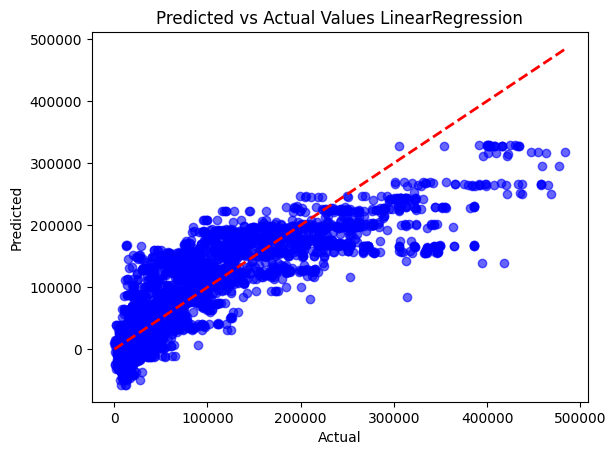

In [27]:
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  
plt.title("Predicted vs Actual Values LinearRegression")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

In [28]:
rf_reg = RandomForestRegressor(random_state=42, n_estimators=500)
rf_model = rf_reg.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)


print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-squared Score:', metrics.r2_score(y_test, y_pred))

mae_rf = metrics.mean_absolute_error(y_test, y_pred)
mse_rf = metrics.mean_squared_error(y_test, y_pred)
rmse_rf = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
r2_rf = metrics.r2_score(y_test, y_pred)

Mean Absolute Error: 5495.358680769179
Mean Squared Error: 189621293.4611828
Root Mean Squared Error: 13770.304770090705
R-squared Score: 0.9738585789069584


In [29]:
scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("Cross-Validation RMSE:", (-scores.mean())**0.5)

Cross-Validation RMSE: 13756.82919312258


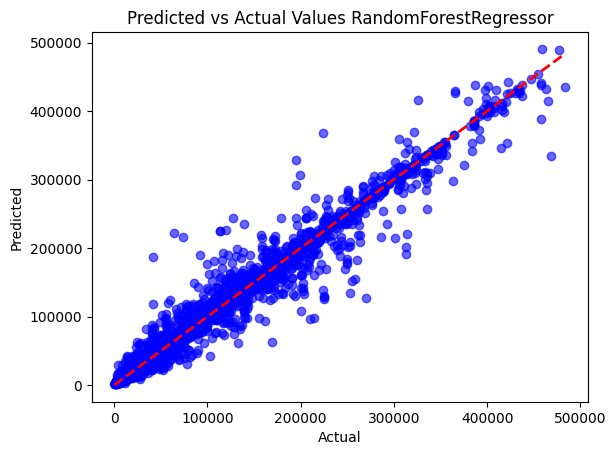

In [30]:
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) 
plt.title("Predicted vs Actual Values RandomForestRegressor")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

In [31]:
model_dt = DecisionTreeRegressor(random_state=42) 
model_dt.fit(X_train, y_train) 

DecisionTreeRegressor(random_state=42)

In [32]:
y_pred = model_dt.predict(X_test)

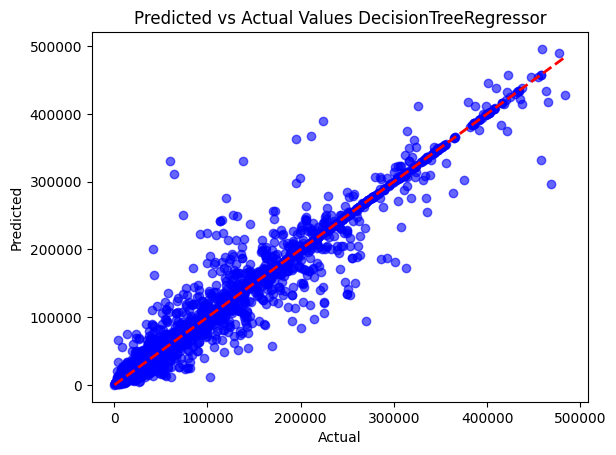

In [33]:
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) 
plt.title("Predicted vs Actual Values DecisionTreeRegressor")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

In [34]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-squared Score:', metrics.r2_score(y_test, y_pred))

mae_dt = metrics.mean_absolute_error(y_test, y_pred)
mse_dt = metrics.mean_squared_error(y_test, y_pred)
rmse_dt = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
r2_dt = metrics.r2_score(y_test, y_pred)

Mean Absolute Error: 5980.421520033045
Mean Squared Error: 297285350.3341349
Root Mean Squared Error: 17241.96480492101
R-squared Score: 0.9590158816764536


In [35]:
scores = cross_val_score(model_dt, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("Cross-Validation RMSE:", (-scores.mean())**0.5)

Cross-Validation RMSE: 16966.40993051063


In [36]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [37]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [38]:
model_nn = Sequential([
    Input(shape=(X_train.shape[1],)), 
    Dense(128, activation='relu'),
    Dropout(0.3),  
    Dense(64, activation='relu'),
    Dropout(0.2), 
    Dense(32, activation='relu'),
    Dense(1)  
])

In [39]:
model_nn.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

model_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               14464     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 24833 (97.00 KB)
Trainable params: 24833 (

Epoch 1/50
565/565 [==============================] - 3s 3ms/step - loss: 7384915968.0000 - mae: 53532.2969 - val_loss: 2431148288.0000 - val_mae: 31923.3848
Epoch 2/50
565/565 [==============================] - 2s 3ms/step - loss: 1942507520.0000 - mae: 27768.3457 - val_loss: 1848252416.0000 - val_mae: 26652.7227
Epoch 3/50
565/565 [==============================] - 1s 3ms/step - loss: 1625638272.0000 - mae: 25007.2520 - val_loss: 1620407936.0000 - val_mae: 24390.7383
Epoch 4/50
565/565 [==============================] - 1s 3ms/step - loss: 1466043904.0000 - mae: 23411.4219 - val_loss: 1454431488.0000 - val_mae: 22979.1387
Epoch 5/50
565/565 [==============================] - 1s 3ms/step - loss: 1287363840.0000 - mae: 21789.1309 - val_loss: 1324034816.0000 - val_mae: 21603.6562
Epoch 6/50
565/565 [==============================] - 1s 3ms/step - loss: 1188703616.0000 - mae: 20791.5332 - val_loss: 1211857408.0000 - val_mae: 20609.7910
Epoch 7/50
565/565 [==============================] 

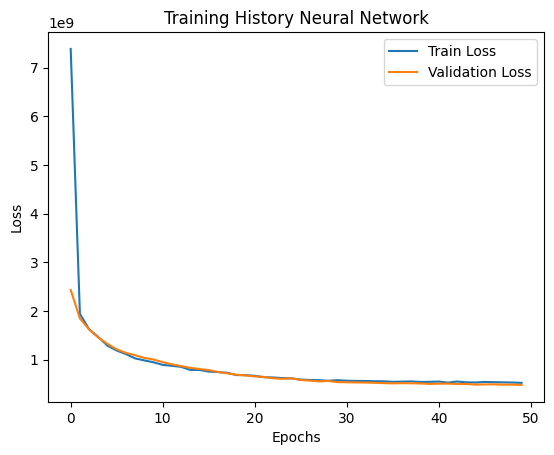

In [40]:
history = model_nn.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)


plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training History Neural Network')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [41]:
y_pred = model_nn.predict(X_test)

rmse_nn = mean_squared_error(y_test, y_pred, squared=False)
r2_nn = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse_nn}")
print(f"R² Score: {r2_nn}")

177/177 [==============================] - 0s 1ms/step
Root Mean Squared Error (RMSE): 20361.591976471183
R² Score: 0.9428435102274361


In [42]:
results = pd.DataFrame({
    "Model": ["Random Forest Model", "Linear Regression Model", "Decision Tree Model", "Neural Network Model"],
    "RMSE": [rmse_rf, rmse_lr, rmse_dt, rmse_nn],
    "R² Score": [r2_rf, r2_lr, r2_dt, r2_nn]
})

print(results)

                     Model          RMSE  R² Score
0      Random Forest Model  13770.304770  0.973859
1  Linear Regression Model  42907.587459  0.746189
2      Decision Tree Model  17241.964805  0.959016
3     Neural Network Model  20361.591976  0.942844


In [43]:
rf_reg = RandomForestRegressor(random_state=42, n_estimators=500)
rf_reg_final = rf_reg.fit(X_train, y_train)


model = rf_reg_final.fit(X_train, y_train)

y_pred = model.predict(X_test)


print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-squared Score:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 5495.358680769179
Mean Squared Error: 189621293.4611828
Root Mean Squared Error: 13770.304770090705
R-squared Score: 0.9738585789069584


In [44]:
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("Cross-Validation RMSE:", (-scores.mean())**0.5)

Cross-Validation RMSE: 13756.82919312258


In [45]:
joblib.dump(model, 'final_model.pkl')

loaded_model = joblib.load('final_model.pkl')

predictions = loaded_model.predict(X_test)

In [47]:
train_pred = loaded_model.predict(X_train)
print("Training Set:")
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_train, train_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_train, train_pred)))
print('R-squared Score:', metrics.r2_score(y_train, train_pred))

print("\nTest Set:")
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, predictions))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R-squared Score:', metrics.r2_score(y_test, predictions))


Training Set:
Mean Absolute Error (MAE): 2026.6550240270797
Root Mean Squared Error (RMSE): 5062.611077211609
R-squared Score: 0.9964443693322453

Test Set:
Mean Absolute Error (MAE): 5495.358680769179
Root Mean Squared Error (RMSE): 13770.304770090705
R-squared Score: 0.9738585789069584


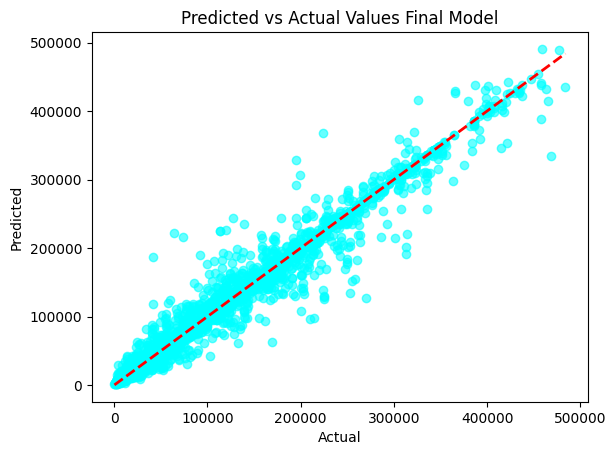

In [48]:
plt.scatter(y_test, predictions, color='cyan', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) 
plt.title("Predicted vs Actual Values Final Model")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()